In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [40]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [43]:
engine.execute('SELECT max(date) FROM Measurement').fetchall()

[('2017-08-23',)]

In [209]:
inspector = inspect(engine)
columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [23]:
# reflect an existing database into a new model
Base = automap_base()


In [24]:
# We can view all of the classes that automap found
Base.prepare(engine, reflect=True)

In [25]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [26]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [67]:
# Calculate the date 1 year ago from the last data point in the database
max_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(max_date)

('2017-08-23',)


In [86]:

prcp_label = session.query(Measurement.date).filter(func.strftime("%d", Measurement.date) == "23").filter(Measurement.date >= dt.date(2016,8,23)).group_by(Measurement.date).\
    order_by(Measurement.date).all()
prcp_label
prcp_loc = [28,56,84,112,140,168,196,224,252,280,308,336,364]
prcp_loc

[28, 56, 84, 112, 140, 168, 196, 224, 252, 280, 308, 336, 364]

In [78]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
sel1 = [Measurement.date,
       Measurement.prcp]

# Perform a query to retrieve the data and precipitation scores
prcp_data = session.query(*sel1).\
    filter(Measurement.date >= dt.date(2016,8,23)).\
    group_by(Measurement.date).\
    order_by(Measurement.date).all()
prcp_data

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_data, columns=['date', 'precipitation'])
# Sort the dataframe by date
prcp_df.set_index('date', inplace = True)
prcp_df = prcp_df.fillna(0)
prcp_df

,precipitation
date,
2016-08-23,0.70
2016-08-24,1.45
2016-08-25,0.11
2016-08-26,0.01
2016-08-27,0.00
...,...
2017-08-19,0.09
2017-08-20,0.00
2017-08-21,0.56


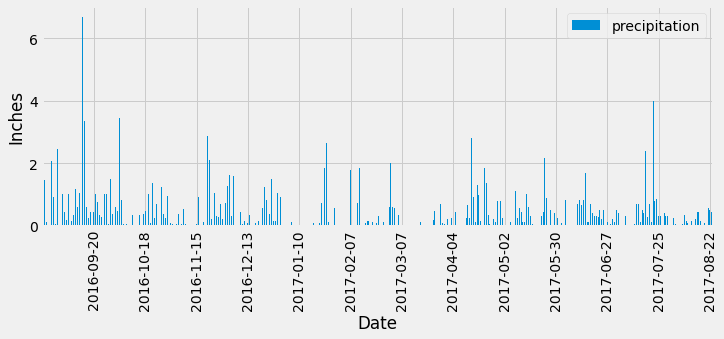

In [207]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot.bar(figsize=(10,5))
plt.tight_layout()
plt.xticks(ticks = prcp_loc, label = prcp_label)
plt.ylabel("Inches")
plt.xlabel("Date")
plt.savefig('precipitation.png')
plt.show()


In [93]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,precipitation
count,366.000000
mean,0.407295
std,0.691164
min,0.000000
25%,0.000000
50%,0.110000
75%,0.545000
max,6.700000


In [97]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station).count()
print("In this dataset there are " + str(station_count) + " stations." )

In this dataset there are 9 stations.


In [117]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sel2 = [Measurement.station,
        func.count(Measurement.station),
        func.avg(Measurement.tobs),
        func.max(Measurement.tobs),
        func.min(Measurement.tobs)]
active_station = session.query(*sel2).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_station
station_df = pd.DataFrame(active_station, columns = ['Station_ID', 'Measurement_Count', 'AVG_TEMP', 'MAX_TEMP', 'MIN_TEMP'])
station_df.set_index('Station_ID', inplace = True)
station_df

,Measurement_Count,AVG_TEMP,MAX_TEMP,MIN_TEMP
Station_ID,,,,
USC00519281,2772,71.663781,85.0,54.0
USC00519397,2724,74.553231,87.0,56.0
USC00513117,2709,72.689184,85.0,59.0
USC00519523,2669,74.543649,85.0,56.0
USC00516128,2612,70.915008,84.0,58.0
USC00514830,2202,74.873297,85.0,58.0
USC00511918,1979,71.615968,87.0,53.0
USC00517948,1372,74.684402,87.0,58.0
USC00518838,511,72.724070,83.0,58.0


In [151]:
def binning(define, output):
    decimal = [.08,.16,.24,.32,.4,.48,.56,.65,.72,.8,.88,1]
    
    for point in decimal:
        quart = define.quantile(point)
        output.append(quart)
        
    return output

In [191]:
tst = [58,61,63,65,67,69,71,73,75,77,79,81,84]
bins = [1,2,3,4,5,6,7,8,9,10,11,12]
tst2 = [61,63,65,67,69,71,73,75,77,79,81,84]
bins2 = [0,1,2,3,4,5,6,7,8,9,10,11]

In [180]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel3 = [Measurement.tobs,
       func.count(Measurement.tobs)]
active_year = session.query(Measurement.tobs).filter(Measurement.date >= dt.date(2016,8,23)).filter(Measurement.station == "USC00519281").filter(Measurement.tobs).order_by(Measurement.tobs).all()
active_year
active_year_df = pd.DataFrame(active_year, columns =["Temperature"])
active_year_df["bins"] = pd.cut(active_year_df["Temperature"], tst, labels = bins)
grouped_year_df = active_year_df.groupby('bins').count()
grouped_year_df.head(20)
grouped_year_df.rename(columns= {"Temperature": "Frequency"})
grouped_year_df

,Temperature
bins,
1,6
2,10
3,10
4,20
5,31
6,40
7,40
8,72
9,64


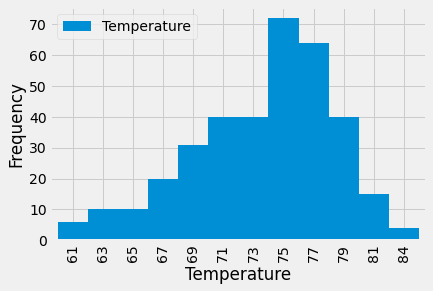

In [208]:
grouped_year_df.rename(columns= {"Temperature": "Frequency"})
grouped_year_df.plot.bar(width = 1)
plt.xticks(ticks = bins2, labels = tst2)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.savefig("temp_freq.png")
plt.show()

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
